In [1]:
import os
import zipfile
import requests
from tqdm import tqdm

# Download Flickr8k dataset (Images + Captions)
image_url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip"
caption_url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip"

# Create dataset directory
os.makedirs("flickr8k", exist_ok=True)

# Download Images
image_zip_path = "flickr8k/Flickr8k_Dataset.zip"
if not os.path.exists(image_zip_path):
    print("Downloading Flickr8k Images...")
    with open(image_zip_path, "wb") as f:
        f.write(requests.get(image_url).content)

# Extract Images
with zipfile.ZipFile(image_zip_path, "r") as zip_ref:
    zip_ref.extractall("flickr8k")

# Download Captions
caption_zip_path = "flickr8k/Flickr8k_text.zip"
if not os.path.exists(caption_zip_path):
    print("Downloading Flickr8k Captions...")
    with open(caption_zip_path, "wb") as f:
        f.write(requests.get(caption_url).content)

# Extract Captions
with zipfile.ZipFile(caption_zip_path, "r") as zip_ref:
    zip_ref.extractall("flickr8k")


In [2]:
import numpy as np
import chromadb
from PIL import Image
from sentence_transformers import SentenceTransformer
from transformers import CLIPProcessor, CLIPModel


d:\work_station\mindflix\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load CLIP Model
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Load Sentence Transformer for text embedding
text_model = SentenceTransformer("all-MiniLM-L6-v2")

# Initialize ChromaDB for storing embeddings
chroma_client = chromadb.PersistentClient(path="./chroma_db")
collection = chroma_client.get_or_create_collection(name="image_search")


d:\work_station\mindflix\myenv\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Akshat\.cache\huggingface\hub\models--openai--clip-vit-base-patch32. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
d:\work_station\mindflix\myenv\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `hugging

In [7]:
import pandas as pd

# Load captions
caption_file = "flickr8k/Flickr8k.token.txt"
caption_data = pd.read_csv(caption_file, delimiter="\t", header=None, names=["file_name","image_caption"])

# Create dictionary: {image_name: caption}
image_captions = {}
for row in caption_data.itertuples():
    # print(row)
    image_name= row.file_name.split("#")[0]
    caption = row.image_caption
    image_name = image_name.split("#")[0]  # Remove caption number (e.g., image1#0.jpg)

    if image_name not in image_captions:
        image_captions[image_name] = caption

In [8]:
def get_clip_embedding(image: Image.Image):
    """Generate CLIP image embedding"""
    inputs = clip_processor(images=image, return_tensors="pt")
    image_features = clip_model.get_image_features(**inputs)
    return image_features.detach().numpy().flatten()

def get_text_embedding(text: str):
    """Generate text embedding (512D)"""
    return text_model.encode(text)


In [10]:
import glob
from tqdm import tqdm

# Get all image paths
image_dir = "flickr8k/Flicker8k_Dataset/"
image_paths = glob.glob(image_dir + "*.jpg")

def add_image_to_db(image_path):
    image_name = os.path.basename(image_path)
    if image_name not in image_captions:
        return

    existing_entry = collection.get(ids=[image_name])
    if len(existing_entry["ids"]) > 0:
        # print(f"⚠️ Skipping duplicate: {image_name}")
        return

    caption = image_captions[image_name]
    image = Image.open(image_path).convert("RGB")
    image_embedding = get_clip_embedding(image)

    text_embedding = get_text_embedding(caption)

    image_embedding /= np.linalg.norm(image_embedding)
    text_embedding /= np.linalg.norm(text_embedding)

    combined_embedding = np.concatenate((image_embedding, text_embedding))
    # Store in ChromaDB
    collection.add(
        ids=[image_name],  # Store image_name as ID
        embeddings=[combined_embedding.tolist()],
        metadatas=[{"caption": caption, "image_path": image_path}],
    )


print("📥 Adding Images to Database...")
for img_path in tqdm(image_paths[:500], desc="Processing Images", unit="image"):
    add_image_to_db(img_path)

📥 Adding Images to Database...


Processing Images: 100%|██████████| 500/500 [00:40<00:00, 12.43image/s]


In [11]:
def retrieve_similar_images(query_embedding, top_k=5):
    results = collection.query(query_embeddings=[query_embedding.tolist()],n_results=top_k)
    retrieved_images = []
    for i in range(len(results["ids"][0])):
        image_id = results["ids"][0][i]
        metadata = results["metadatas"][0][i]
        retrieved_images.append(metadata)

    return retrieved_images


In [12]:
def search_by_image(image_path):
    """Retrieve images similar to an input image"""
    image = Image.open(image_path).convert("RGB")
    image_embedding = get_clip_embedding(image)
    image_embedding /= np.linalg.norm(image_embedding)

    padded_embedding = np.concatenate((image_embedding, np.zeros(384)))  # 896-D
    return retrieve_similar_images(padded_embedding)

In [13]:
def search_by_text(query_text):
    """Retrieve images similar to an input text query"""
    text_embedding = get_text_embedding(query_text)
    text_embedding /= np.linalg.norm(text_embedding)

    # Pad with zeros to match 896-D (Assume text embedding is unknown)
    padded_embedding = np.concatenate((np.zeros(512),text_embedding))  # 896-D
    return retrieve_similar_images(padded_embedding)


In [25]:
def search_by_image_and_text(image_path, query_text):
    """Retrieve images based on both image and text query"""
    image = Image.open(image_path).convert("RGB")
    image_embedding = get_clip_embedding(image)
    text_embedding = get_text_embedding(query_text)

    image_embedding /= np.linalg.norm(image_embedding)
    text_embedding /= np.linalg.norm(text_embedding)

    combined_embedding = np.concatenate((image_embedding, text_embedding))
    return retrieve_similar_images(combined_embedding)


In [19]:
import matplotlib.pyplot as plt
import textwrap
from PIL import Image

# Function to display results in a single-row format with captions below images
def display_results(title, results):
    num_results = min(len(results), 5)  # Limit to top 5 results

    if num_results == 0:
        print(f"\n No results found for {title}!\n")
        return

    fig, axes = plt.subplots(1, num_results, figsize=(15, 3))  # Single row layout
    fig.suptitle(title, fontsize=14, fontweight="bold")

    # If only one image, axes is not an array, so wrap it in a list
    if num_results == 1:
        axes = [axes]

    for i, res in enumerate(results[:5]):  # Show max 5 images
        img_path = res["image_path"].split("/content/")[-1]
        caption = res["caption"]

        axes[i].imshow(Image.open(img_path))
        axes[i].axis("off")

        # Wrap text caption to fit below the image
        wrapped_caption = "\n".join(textwrap.wrap(caption, width=30))
        axes[i].set_title(wrapped_caption, fontsize=10, pad=5)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit title properly
    plt.show()




In [17]:
image_paths[1001]

'flickr8k/Flicker8k_Dataset\\2099323664_bb20457f26.jpg'

📌 **Query Image:**


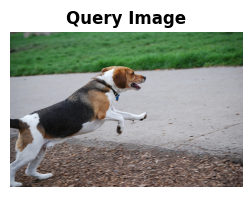

🔍 **Query Text:** A white dog jumping



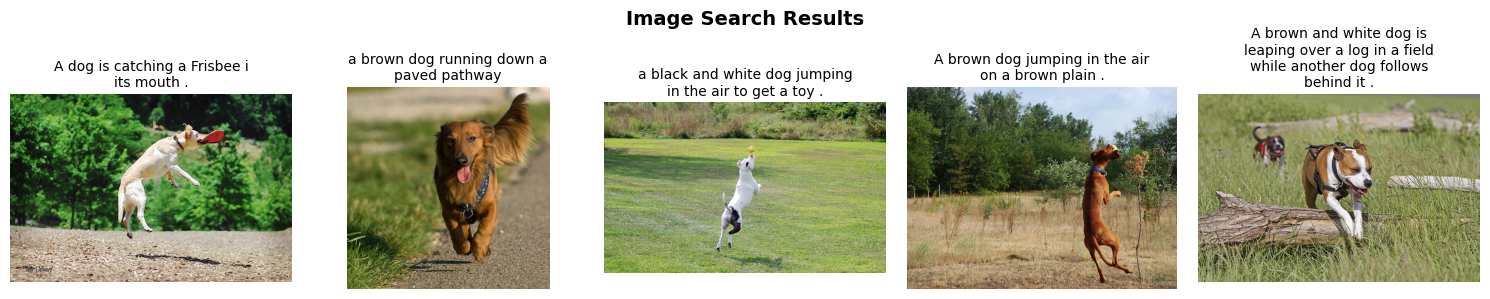

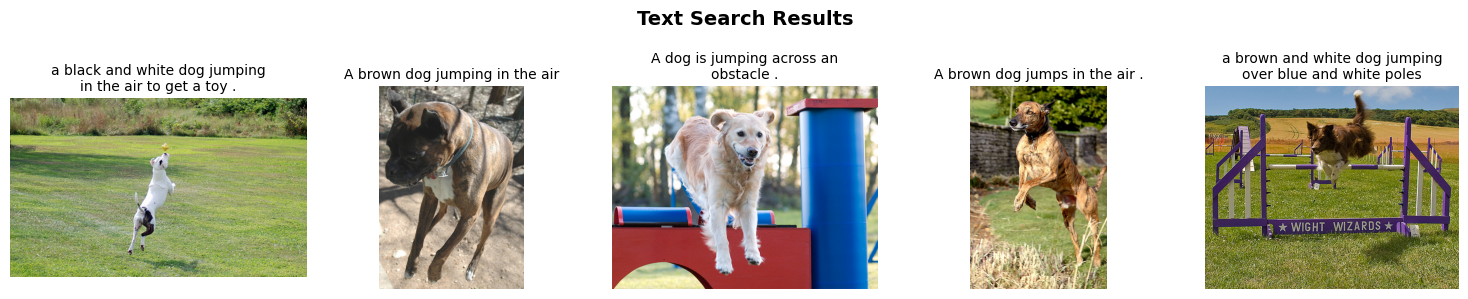

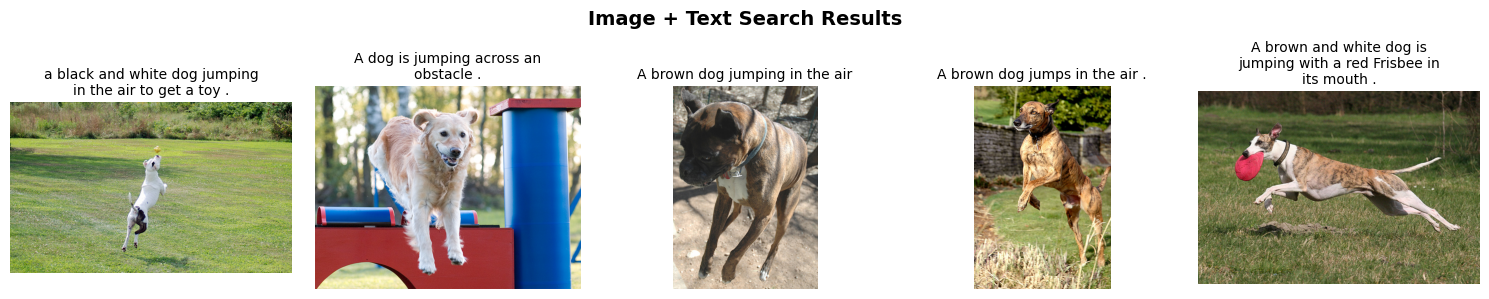

In [29]:
# Pick an image from the dataset for testing
test_image_path = image_paths[1001]  # Change index as needed
test_query_text = "A white dog jumping"

# Display the test query image
print("📌 **Query Image:**")
plt.figure(figsize=(3, 3))
plt.imshow(Image.open(test_image_path))
plt.axis("off")
plt.title("Query Image", fontsize=12, fontweight="bold")
plt.show()

print(f"🔍 **Query Text:** {test_query_text}\n")


# Query 1: Image Search
img_results = search_by_image(test_image_path)
display_results("Image Search Results", img_results)
print()


# Query 2: Text Search
text_results = search_by_text(test_query_text)
display_results("Text Search Results", text_results)
print()


# Query 3: Image + Text Search
whole_results = search_by_image_and_text(test_image_path, test_query_text)
display_results("Image + Text Search Results", whole_results)
